# Import Dataset and Libraries

In [1]:
%pip install imbalanced-learn==0.10.1
%pip install catboost==1.1.1
%pip install pycountry==22.1.10
%pip install scikit-learn==1.2.2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
import numpy as np
import pandas as pd

RANDOM_STATE = 42
TRAIN_FILE = "./train.csv"
TEST_FILE = "./test.csv"

In [3]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)
df_submission = pd.read_csv(TEST_FILE)

In [4]:
X, y = df_train.drop("is_converted", axis=1), df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

# Data Preprocessing

## 1. Data Imputation

In [5]:
values = {
    **{column: 0 for column in X.columns},
    "inquiry_type": "Quotation or Purchase Consultation",
    "customer_country": "Not Found",
    "historical_existing_cnt": X["historical_existing_cnt"].mode()[0],
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

## 2. Data Cleaning 

### Feature: Customer Country

In [6]:
import pycountry


def preprocess_country(country):
    if not isinstance(country, str):
        return "Not Found"

    country = country.split("/")[-1].strip()
    country = pycountry.countries.get(name=country)
    return "Not Found" if country is None else country.alpha_3


X["customer_country"] = [
    preprocess_country(country) for country in X["customer_country"]
]

X_test["customer_country"] = [
    preprocess_country(country) for country in X_test["customer_country"]
]

### Feature: Business Unit ("business_unit")

In [7]:
X["business_unit"] = X["business_unit"].astype(
    pd.CategoricalDtype(categories=["ID", "AS", "IT", "Solution", "CM"])
)
X_test["business_unit"] = X_test["business_unit"].astype(
    pd.CategoricalDtype(categories=["ID", "AS", "IT", "Solution", "CM"])
)

In [8]:
# # 각 비즈니스 유닛에 대한 가중치 - id_strategic_ver가 1/ it_strategic_ver == 0인 경우에만 
weights = {
    "ID": 0.064566116,
    "AS": 0.026845638,
    "IT": 0,
    "Solution": 0.034482759,
    "CM": 0,
    #ver_win_ratio_per_bu를 보고 business_unit별로 부여
}

#map with business unit
X['business_weight'] = X.apply(lambda row: weights[row['business_unit']] if row['id_strategic_ver'] == 1 else 0, axis=1)
X_test['business_weight'] = X_test['business_unit'].apply(lambda x: weights[x])

### Feature: Inquiry Type ("inquiry_type")

In [9]:
inquiry_type_remap = {
    # Quotation: Asking about the product itself.
    "Q": [
        "Quotation or Purchase Consultation",
        "Quotation or purchase consultation",
        "Quotation or Purchase consultation",
        "quotation_or_purchase_consultation",
        "Purchase or Quotation",
        "Purchase",
        "Request for quotation or purchase",
        "Sales Inquiry",
        "sales",
        "quotation_",
    ],
    # Usage: Asking about how to use the product.
    "U": [
        "Usage or Technical Consultation",
        "Usage or technical consultation",
        "usage or technical consultation",
        "usage_or_technical_consultation",
        "Technical Consultation",
        "Technical Support",
        "technical",
        "technical_consultation",
        "Request for technical consulting",
        "Product Information",
        "i want to know the details about it",
        "first Info and pricing",
        "Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung",
        "tôi cần tham khảo giá và giải pháp từ LG",
        "Trainings",
    ],
    "O": [
        "Other",
        "Others",
        "other_",
        "other",
        "others",
        "Etc.",
        "ETC.",
        "Not specified",
        "(Select ID_Needs)",
        "IDB",
        "Services",
        "Request for Partnership",
        "Request a Demo",
        "Request for Distributorship",
        "Customer Suggestions",
        *(
            df_train["inquiry_type"]
            .value_counts()
            .loc[df_train["inquiry_type"].value_counts() < 10]
            .index.tolist()
        ),
    ],
}

for key, value in inquiry_type_remap.items():
    X.loc[X["inquiry_type"].isin(value), "inquiry_type"] = key
    X_test.loc[X_test["inquiry_type"].isin(value), "inquiry_type"] = key

### Feature: Customer Position ("customer_position")

In [10]:
X['customer_position'] = X['customer_position'].replace('decision maker', 'decision-maker')
X['customer_position'] = X['customer_position'].replace('decision influencer', 'decision-influencer')
X['customer_position'] = X['customer_position'].replace('architect/consultant', 'architecture/consult')
X['customer_position'] = X['customer_position'].replace('physics and mathematics teacher', 'math and physics teacher')
X['customer_position'] = X['customer_position'].replace('vicepresident', 'vice president')
X['customer_position'] = X['customer_position'].replace('others', 'other')

X_test['customer_position'] = X_test['customer_position'].replace('decision influencer', 'decision-influencer')
X_test['customer_position'] = X_test['customer_position'].replace('architect/consultant', 'architecture/consult')
X_test['customer_position'] = X_test['customer_position'].replace('physics and mathematics teacher', 'math and physics teacher')
X_test['customer_position'] = X_test['customer_position'].replace('vicepresident', 'vice president')
X_test['customer_position'] = X_test['customer_position'].replace('others', 'other')

In [11]:
# Classification by position and occupation
C_position_high_executive = [
    'manager', 'ceo/founder', 'c-level executive',
    'vice president', 'c-levelexecutive', 'founder',
    'commercial consultant', 'government',
    'operations', 'other - please specify - cedia association',
    'leadership/executive office/owner', 'market intelligence/research',
    'chairman', 'co-founder', 'chief executive officer',
    'ceo/fundador', 'gerente', 'president', 'genel müdür', 'bulgaria',
]

C_position_low_executive = [
    'director', 'intern', 'trainee', 'entry level',
    'employee', 'administrative', 'manufacturer',
    'system integrator', 'distributor', 'business unit director',
    'business development', 'product management', 'business partner',
    'subsidiary sales (ise)', 'business development/sales',
    'sales',
]

C_position_education = [
    'physics teacher', 'assistant professor',
    'maths lecturer', 'science teacher', 'physics faculty',
    'teacher/middle school coordinator', 'math and physics teacher',
    'professor of mathematics', 'prof.', 'professor of mathematics',
    'academic specialist', 'principal at oxford integrated pu science college'
    'assistant professor of English', 'educator', 'professor',
    'quantitative aptitude faculty', 'english trainer for ielts,toefl,pte,gre,sat exams.'
    'associate professor', 'principal & director', 'hon dean',
    'pgt physics', 'education professional', 'chemistry teacher',
    'director cum faculty at gaining apex coaching centre',
    'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)',
    'teacher', 'senior lecturer', 'neet/ olympiad expert faculty',
    'asst prof.', 'associate professor in electronics engg', 'professional trainer',
    'education',
]

C_position_hospital = [
    'hospital', 'medical device manufacturer', 'vp', 'medical imaging specialist',
    'tierarzt', 'főorvos', 'surgery professional', 'pathologist', 'radiology professional'
]

C_position_others = [
    'entry level', 'customer', 'technical',
    'exhibition', 'end-user', 'cargo', 'técnico', 'exhibitiontv',
    'proprietário(a)', 'mindenes', 'research', 'the big boss',
    'partner', 'associate/analyst', 'none', 'unpaid', 'av management',
    'engineering', 'installer', 'homeowner', 'commercial end-user'
    'lider de desarrollo', 'entrepreneurship', 'not applicable',
    'no influence',
]

C_position_consultant = [
    'consultant', 'software/solution provider', 'guest faculty',
    'career coach', 'consulting',
]


In [12]:
position_category= {
    'High Executive': C_position_high_executive,
    'Low Executive': C_position_low_executive,
    'Education': C_position_education,
    'Hospital': C_position_hospital,
    'Consultant': C_position_consultant,
    'Others': C_position_others
}

for category, positions in position_category.items():
    X.loc[X['customer_position'].isin(positions), 'C_position_1'] = category
    X_test.loc[X_test['customer_position'].isin(positions), 'C_position_1'] = category

# 'Hospital', 'Consultant', 'Education'는 무의미한 데이터로 판단 -> Others로 대체
categories_drop = ['Hospital', 'Consultant', 'Education']
X.loc[X['C_position_1'].isin(categories_drop), 'C_position_1'] = 'Others'
X_test.loc[X_test['C_position_1'].isin(categories_drop), 'C_position_1'] = 'Others'

# C_position_category one_hot_encoding
X_encoded = pd.get_dummies(X, columns=['C_position_1'])
X_test_encoded = pd.get_dummies(X_test, columns=['C_position_1'])

In [13]:
col =['C_position_1_High Executive', 'C_position_1_Low Executive', 'C_position_1_Others']

X[col] = X_encoded[col].astype(int)
X_test[col] = X_test_encoded[col].astype(int)

In [14]:
# 기존 열 drop
X.drop(['C_position_1'], axis=1, inplace=True)
X.drop(['customer_position'], axis=1, inplace=True)

X_test.drop(['C_position_1'], axis=1, inplace=True)
X_test.drop(['customer_position'], axis=1, inplace=True)

### Feature: Customer Job ("customer_job")

In [15]:
# engineer category
C_job_engineer = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and 'engineer' in job.lower().replace(" ", "").lower():
        C_job_engineer.append(job)

# tech & IT category
C_job_tech = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('tech' in job.lower().replace(" ", "").lower()
                                or 'IT' in job.lower().replace(" ", "").lower()
                                or 'software' in job.lower().replace(" ", "").lower()):
        C_job_tech.append(job)
              
# high_executive category
C_job_high_executive = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('admin' in job.lower().replace(" ", "").lower()
                                or 'entrepreneurship' in job.lower().replace(" ", "").lower()
                                or 'executive' in job.lower().replace(" ", "").lower()
                                or 'owner' in job.lower().replace(" ", "").lower() 
                                or 'manage' in job.lower().replace(" ", "").lower()
                                or 'president' in job.lower().replace(" ", "").lower()
                                or 'CEO' in job.lower().replace(" ","").lower()):
        C_job_high_executive.append(job)

# low_executive category
C_job_low_executive = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('operations' in job.lower().replace(" ", "").lower() 
                                or 'sale' in job.lower().replace(" ", "").lower()
                                or 'marketing' in job.lower().replace(" ", "").lower()
                                or 'business' in job.lower().replace(" ","").lower()):
        C_job_low_executive.append(job)  

# education category
C_job_education = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('education' in job.lower().replace(" ", "").lower() 
                                 or 'professor' in job.lower().replace(" ", "").lower()
                                 or 'educator' in job.lower().replace(" ", "").lower()
                                 or 'teach' in job.lower().replace(" ", "").lower()):
        C_job_education.append(job)

# design category
C_job_design = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('art' in job.lower().replace(" ", "").lower() 
                                 or 'design' in job.lower().replace(" ", "").lower()):
        C_job_design.append(job)

# medical category
C_job_medical = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('medical' in job.lower().replace(" ", "").lower() 
                                 or 'health' in job.lower().replace(" ", "").lower()
                                 or 'care' in job.lower().replace(" ", "").lower()):
        C_job_medical.append(job)
        
# NaN category
C_job_NaN = []
for job in df_train['customer_job'].unique():
    if pd.isna(job):
        C_job_NaN.append(job)

# Other category
C_job_other = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and job not in C_job_engineer + C_job_tech + C_job_high_executive +C_job_medical + C_job_low_executive + C_job_education + C_job_design:
        C_job_other.append(job)


In [16]:
job_category = {
    'Engineer': C_job_engineer,
    'Tech & IT': C_job_tech,
    'high_executive': C_job_high_executive,
    'low_executive': C_job_low_executive,
    'Education': C_job_education,
    'Design': C_job_design,
    'Medical': C_job_medical,
    'NaN': C_job_NaN,
    'Other': C_job_other
}

for category, jobs in job_category.items():
    X.loc[df_train['customer_job'].isin(jobs), 'C_job_category'] = category
    X_test.loc[df_test['customer_job'].isin(jobs), 'C_job_category'] = category

    
# C_job_category one_hot_encoding
X_encoded = pd.get_dummies(X, columns=['C_job_category'])
X_test_encoded = pd.get_dummies(X_test, columns=['C_job_category'])

col =['C_job_category_low_executive', 'C_job_category_high_executive', 'C_job_category_Engineer', 'C_job_category_Education',
     'C_job_category_Tech & IT', 'C_job_category_Design', 'C_job_category_Medical', 'C_job_category_Other', 'C_job_category_NaN']



X[col] = X_encoded[col].astype(int)
X_test[col] = X_test_encoded[col].astype(int)


# 기존 열 drop
X.drop(['C_job_category'], axis=1, inplace=True)
X.drop(['customer_job'], axis=1, inplace=True)

X_test.drop(['C_job_category'], axis=1, inplace=True)
X_test.drop(['customer_job'], axis=1, inplace=True)

# 결측치 처리
X.loc[X['C_job_category_NaN'] == 1, 'C_job_category_Other'] = 1
X.drop(['C_job_category_NaN'], axis=1, inplace=True)
X_test.loc[X_test['C_job_category_NaN'] == 1, 'C_job_category_Other'] = 1
X_test.drop(['C_job_category_NaN'], axis=1, inplace=True)

### Feature: Response Corporate ("corporate_category")

In [19]:
def label_encoding(series: pd.Series) -> pd.Series:
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

def categorize(num):
    if num > 4000:
        return 'converted_high'
    elif num > 288:
        return 'converted_middle'
    else:
        return 'converted_low'

In [20]:
converted_counts = X.groupby('response_corporate').size().to_dict()
X['response_corporate_num'] = X['response_corporate'].map(converted_counts).fillna(0).astype(int)
X['corporate_converted_category'] = X['response_corporate_num'].apply(categorize)

converted_counts = X_test.groupby('response_corporate').size().to_dict()
X_test['response_corporate_num'] = X_test['response_corporate'].map(converted_counts).fillna(0).astype(int)
X_test['corporate_converted_category'] = X_test['response_corporate_num'].apply(categorize)


In [21]:
X['corporate_category'] = label_encoding(X["corporate_converted_category"])
X_test['corporate_category'] = label_encoding(X_test["corporate_converted_category"])

In [22]:
del X['corporate_converted_category']
del X_test['corporate_converted_category']

## 3. Feature Engineering

In [18]:
country_frequency = X["customer_country"].value_counts(normalize=True)
X["customer_country_frequency"] = X["customer_country"].map(country_frequency)
X_test["customer_country_frequency"] = X_test["customer_country"].map(country_frequency)

country_target = (
    pd.concat([X, y], axis=1).groupby("customer_country")["is_converted"].mean()
)
X["customer_country_target"] = X["customer_country"].map(country_target)
X_test["customer_country_target"] = X_test["customer_country"].map(country_target)

owner_frequency = X["lead_owner"].value_counts(normalize=True)
X["lead_owner_frequency"] = X["lead_owner"].map(owner_frequency)
X_test["lead_owner_frequency"] = X_test["lead_owner"].map(owner_frequency)

owner_target = pd.concat([X, y], axis=1).groupby("lead_owner")["is_converted"].mean()
X["lead_owner_target"] = X["lead_owner"].map(owner_target)
X_test["lead_owner_target"] = X_test["lead_owner"].map(owner_target)


## 4. Feature Encoding

In [25]:
def encode_features(
    df: pd.DataFrame,
    features=["enterprise", "business_unit", "inquiry_type", "bant_submit"],
) -> pd.DataFrame:
    df_encoded = pd.get_dummies(df[features], columns=features)
    df_encoded = df_encoded.apply(lambda x: x.astype("category").cat.codes)
    df = pd.concat([df, df_encoded], axis=1).drop(features, axis=1)
    return df


X = encode_features(X)
X_test = encode_features(X_test)

## 5. Feature Normalization

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

standard_transformer = Pipeline(steps=[("standardize", StandardScaler())])
column_transformer = ColumnTransformer(
    transformers=[
        ("std", standard_transformer, ["lead_desc_length", "historical_existing_cnt"]),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
column_transformer.set_output(transform="pandas")

X = column_transformer.fit_transform(X)
X_test = column_transformer.transform(X_test)

## 6. Outlier Removal

## 7. Feature Removal

In [28]:
features_to_drop = [
    "customer_country",
    "business_subarea",
    "business_area",
    "customer_idx",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_type",
    "expected_timeline",
    "lead_owner",
    "response_corporate",
    "response_corporate_num"
]

X = X.drop(features_to_drop, axis=1)  # type: ignore
X_test = X_test.drop(features_to_drop, axis=1)  # type: ignore

In [29]:
X.columns.tolist()

['lead_desc_length',
 'historical_existing_cnt',
 'com_reg_ver_win_rate',
 'id_strategic_ver',
 'it_strategic_ver',
 'idit_strategic_ver',
 'ver_cus',
 'ver_pro',
 'ver_win_rate_x',
 'ver_win_ratio_per_bu',
 'business_weight',
 'C_position_1_High Executive',
 'C_position_1_Low Executive',
 'C_position_1_Others',
 'C_job_category_low_executive',
 'C_job_category_high_executive',
 'C_job_category_Engineer',
 'C_job_category_Education',
 'C_job_category_Tech & IT',
 'C_job_category_Design',
 'C_job_category_Medical',
 'C_job_category_Other',
 'customer_country_frequency',
 'customer_country_target',
 'lead_owner_frequency',
 'lead_owner_target',
 'corporate_category',
 'enterprise_Enterprise',
 'enterprise_SMB',
 'business_unit_ID',
 'business_unit_AS',
 'business_unit_IT',
 'business_unit_Solution',
 'business_unit_CM',
 'inquiry_type_O',
 'inquiry_type_Q',
 'inquiry_type_U',
 'bant_submit_0.0',
 'bant_submit_0.25',
 'bant_submit_0.5',
 'bant_submit_0.75',
 'bant_submit_1.0']

# Modeling

In [30]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

# K-Fold Cross Validation

In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold

kfolds, scores = (
    StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True),
    [],
)

for fold_idx, (train_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    sm = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
    X_train, y_train = sm.fit_resample(X_train, y_train)  # type: ignore

    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    prediction = np.where(prediction == "True", True, False)

    print(f"Accuracy (Fold {fold_idx}): {accuracy_score(y_val, prediction)}")
    print(f"Precision (Fold {fold_idx}): {precision_score(y_val, prediction)}")
    print(f"Recall (Fold {fold_idx}): {recall_score(y_val, prediction)}")
    print(f"F1-Score (Fold {fold_idx}): {f1_score(y_val, prediction)}")
    print(
        f"ROC-AUC Score (Fold {fold_idx}): "
        + f"{roc_auc_score(y_val, model.predict_proba(X_val)[:,1])}\n"
    )

    scores.append(f1_score(y_val, prediction))

print(f"Cross-Validation Average F1-Score: {np.mean(scores)}")

Accuracy (Fold 0): 0.9407251264755481
Precision (Fold 0): 0.6091578086672118
Recall (Fold 0): 0.7680412371134021
F1-Score (Fold 0): 0.6794345645234838
ROC-AUC Score (Fold 0): 0.9662235286321509

Accuracy (Fold 1): 0.942327150084317
Precision (Fold 1): 0.6193656093489148
Recall (Fold 1): 0.7649484536082474
F1-Score (Fold 1): 0.6845018450184501
ROC-AUC Score (Fold 1): 0.9707416243030114

Accuracy (Fold 2): 0.9381112984822935
Precision (Fold 2): 0.5924764890282131
Recall (Fold 2): 0.7793814432989691
F1-Score (Fold 2): 0.6731967943009796
ROC-AUC Score (Fold 2): 0.9665100394763

Accuracy (Fold 3): 0.9420741989881957
Precision (Fold 3): 0.6138374899436846
Recall (Fold 3): 0.7865979381443299
F1-Score (Fold 3): 0.6895616809760505
ROC-AUC Score (Fold 3): 0.9677912205466095

Accuracy (Fold 4): 0.9397925626106755
Precision (Fold 4): 0.6045751633986928
Recall (Fold 4): 0.7628865979381443
F1-Score (Fold 4): 0.6745670009115768
ROC-AUC Score (Fold 4): 0.9649318852942486

Cross-Validation Average F1-S

# Create Submission

In [32]:
sm = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
X, y = sm.fit_resample(X, y)  # type: ignore
model.fit(X, y)

prediction = model.predict(X_test)
prediction = np.where(prediction == 1, True, False)

df_submission["is_converted"] = prediction
df_submission.to_csv("submission.csv", index=False)
df_submission.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,False
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,False
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,False


In [33]:
# F1-Score: 0.6802523771461082

In [35]:
model.feature_importances_

array([9.29418536e+00, 6.45068463e+00, 1.26899794e+00, 1.43808181e-01,
       0.00000000e+00, 1.78380479e-01, 4.73749825e-01, 1.84060480e-01,
       7.11407204e+00, 3.30402013e+00, 8.76810519e-02, 3.96049094e-01,
       5.29374544e-01, 6.31590504e-01, 4.79739301e-01, 5.86945464e-01,
       5.62652136e-01, 1.23118669e-01, 2.01669550e-01, 3.03173887e-01,
       1.34459887e-01, 9.97330128e-01, 1.51591317e+01, 8.29306863e+00,
       9.01822702e+00, 2.50636046e+01, 6.96997748e-01, 8.94716547e-01,
       2.46465376e-01, 6.36937301e-01, 9.09572084e-01, 6.57980980e-01,
       1.08881057e-02, 1.10874567e-05, 3.79480025e-01, 5.60904796e-01,
       7.18146590e-01, 1.10429939e-01, 1.38470864e+00, 1.31712950e+00,
       2.41393485e-01, 2.54462558e-01])

In [36]:
feature_names = X.columns.tolist()

<AxesSubplot:>

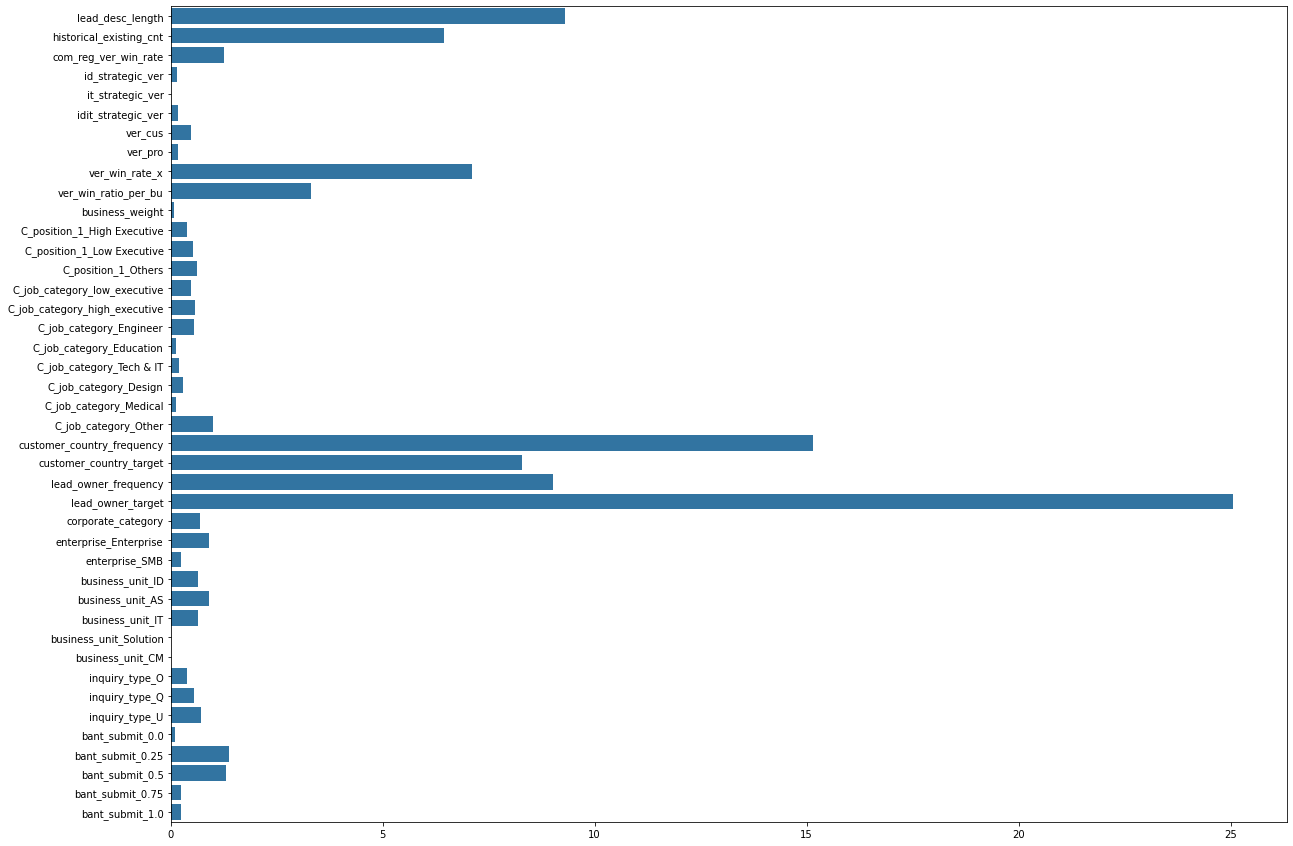

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
sns.barplot(x=model.feature_importances_, y=feature_names)

C:\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Learning rate set to 0.056781
0:	learn: 0.6151770	total: 14.7ms	remaining: 14.7s
1:	learn: 0.5523658	total: 29.8ms	remaining: 14.9s
2:	learn: 0.5034627	total: 44.4ms	remaining: 14.7s
3:	learn: 0.4538081	total: 58.7ms	remaining: 14.6s
4:	learn: 0.4117240	total: 72.4ms	remaining: 14.4s
5:	learn: 0.3735202	total: 88.4ms	remaining: 14.6s
6:	learn: 0.3448168	total: 102ms	remaining: 14.5s
7:	learn: 0.3232922	total: 116ms	remaining: 14.3s
8:	learn: 0.3033954	total: 129ms	remaining: 14.2s
9:	learn: 0.2884096	total: 144ms	remaining: 14.2s
10:	learn: 0.2751697	total: 158ms	remaining: 14.2s
11:	learn: 0.2629729	total: 173ms	remaining: 14.2s
12:	learn: 0.2517419	total: 187ms	remaining: 14.2s
13:	learn: 0.2426982	total: 202ms	remaining: 14.2s
14:	learn: 0.2360522	total: 217ms	remaining: 14.3s
15:	learn: 0.2274625	total: 232ms	remaining: 14.2s
16:	learn: 0.2223832	total: 247ms	remaining: 14.3s
17:	learn: 0.2170938	total: 261ms	remaining: 14.2s
18:	learn: 0.2133698	total: 275ms	remaining: 14.2s
19:	l

167:	learn: 0.1048638	total: 2.97s	remaining: 14.7s
168:	learn: 0.1042990	total: 2.99s	remaining: 14.7s
169:	learn: 0.1041614	total: 3.01s	remaining: 14.7s
170:	learn: 0.1040428	total: 3.03s	remaining: 14.7s
171:	learn: 0.1039122	total: 3.05s	remaining: 14.7s
172:	learn: 0.1034446	total: 3.07s	remaining: 14.7s
173:	learn: 0.1032004	total: 3.08s	remaining: 14.6s
174:	learn: 0.1030449	total: 3.1s	remaining: 14.6s
175:	learn: 0.1028768	total: 3.12s	remaining: 14.6s
176:	learn: 0.1026990	total: 3.14s	remaining: 14.6s
177:	learn: 0.1025661	total: 3.16s	remaining: 14.6s
178:	learn: 0.1024293	total: 3.18s	remaining: 14.6s
179:	learn: 0.1022434	total: 3.2s	remaining: 14.6s
180:	learn: 0.1020896	total: 3.22s	remaining: 14.6s
181:	learn: 0.1018733	total: 3.24s	remaining: 14.6s
182:	learn: 0.1017316	total: 3.26s	remaining: 14.5s
183:	learn: 0.1015692	total: 3.27s	remaining: 14.5s
184:	learn: 0.1014875	total: 3.29s	remaining: 14.5s
185:	learn: 0.1010922	total: 3.31s	remaining: 14.5s
186:	learn: 0.

333:	learn: 0.0778488	total: 6.11s	remaining: 12.2s
334:	learn: 0.0777102	total: 6.13s	remaining: 12.2s
335:	learn: 0.0775779	total: 6.15s	remaining: 12.2s
336:	learn: 0.0774032	total: 6.17s	remaining: 12.1s
337:	learn: 0.0772337	total: 6.18s	remaining: 12.1s
338:	learn: 0.0771088	total: 6.2s	remaining: 12.1s
339:	learn: 0.0769399	total: 6.22s	remaining: 12.1s
340:	learn: 0.0768086	total: 6.24s	remaining: 12.1s
341:	learn: 0.0766873	total: 6.26s	remaining: 12s
342:	learn: 0.0766160	total: 6.28s	remaining: 12s
343:	learn: 0.0765049	total: 6.3s	remaining: 12s
344:	learn: 0.0764119	total: 6.31s	remaining: 12s
345:	learn: 0.0762958	total: 6.33s	remaining: 12s
346:	learn: 0.0762190	total: 6.35s	remaining: 11.9s
347:	learn: 0.0760791	total: 6.37s	remaining: 11.9s
348:	learn: 0.0759865	total: 6.38s	remaining: 11.9s
349:	learn: 0.0758397	total: 6.41s	remaining: 11.9s
350:	learn: 0.0757299	total: 6.43s	remaining: 11.9s
351:	learn: 0.0756406	total: 6.45s	remaining: 11.9s
352:	learn: 0.0755506	to

496:	learn: 0.0638155	total: 9.21s	remaining: 9.32s
497:	learn: 0.0637784	total: 9.22s	remaining: 9.3s
498:	learn: 0.0636835	total: 9.24s	remaining: 9.28s
499:	learn: 0.0636579	total: 9.26s	remaining: 9.26s
500:	learn: 0.0636074	total: 9.28s	remaining: 9.24s
501:	learn: 0.0635759	total: 9.29s	remaining: 9.22s
502:	learn: 0.0634874	total: 9.31s	remaining: 9.2s
503:	learn: 0.0634211	total: 9.33s	remaining: 9.19s
504:	learn: 0.0633182	total: 9.35s	remaining: 9.17s
505:	learn: 0.0632535	total: 9.37s	remaining: 9.15s
506:	learn: 0.0631969	total: 9.39s	remaining: 9.13s
507:	learn: 0.0630659	total: 9.41s	remaining: 9.11s
508:	learn: 0.0630182	total: 9.42s	remaining: 9.09s
509:	learn: 0.0629855	total: 9.44s	remaining: 9.07s
510:	learn: 0.0629107	total: 9.46s	remaining: 9.05s
511:	learn: 0.0628377	total: 9.47s	remaining: 9.03s
512:	learn: 0.0627913	total: 9.49s	remaining: 9.01s
513:	learn: 0.0627367	total: 9.51s	remaining: 8.99s
514:	learn: 0.0625791	total: 9.53s	remaining: 8.97s
515:	learn: 0.

660:	learn: 0.0547407	total: 12.3s	remaining: 6.33s
661:	learn: 0.0546961	total: 12.4s	remaining: 6.31s
662:	learn: 0.0546509	total: 12.4s	remaining: 6.29s
663:	learn: 0.0545974	total: 12.4s	remaining: 6.27s
664:	learn: 0.0545681	total: 12.4s	remaining: 6.25s
665:	learn: 0.0544653	total: 12.4s	remaining: 6.23s
666:	learn: 0.0544144	total: 12.4s	remaining: 6.21s
667:	learn: 0.0543337	total: 12.5s	remaining: 6.2s
668:	learn: 0.0542908	total: 12.5s	remaining: 6.17s
669:	learn: 0.0542813	total: 12.5s	remaining: 6.16s
670:	learn: 0.0542094	total: 12.5s	remaining: 6.14s
671:	learn: 0.0541855	total: 12.5s	remaining: 6.12s
672:	learn: 0.0541521	total: 12.6s	remaining: 6.1s
673:	learn: 0.0541065	total: 12.6s	remaining: 6.08s
674:	learn: 0.0540748	total: 12.6s	remaining: 6.06s
675:	learn: 0.0540515	total: 12.6s	remaining: 6.04s
676:	learn: 0.0540033	total: 12.6s	remaining: 6.02s
677:	learn: 0.0539672	total: 12.6s	remaining: 6s
678:	learn: 0.0539287	total: 12.7s	remaining: 5.98s
679:	learn: 0.053

827:	learn: 0.0479448	total: 15.5s	remaining: 3.21s
828:	learn: 0.0478919	total: 15.5s	remaining: 3.19s
829:	learn: 0.0478638	total: 15.5s	remaining: 3.17s
830:	learn: 0.0478259	total: 15.5s	remaining: 3.16s
831:	learn: 0.0478017	total: 15.5s	remaining: 3.14s
832:	learn: 0.0477708	total: 15.6s	remaining: 3.12s
833:	learn: 0.0477234	total: 15.6s	remaining: 3.1s
834:	learn: 0.0476850	total: 15.6s	remaining: 3.08s
835:	learn: 0.0476500	total: 15.6s	remaining: 3.06s
836:	learn: 0.0475857	total: 15.6s	remaining: 3.04s
837:	learn: 0.0475567	total: 15.6s	remaining: 3.02s
838:	learn: 0.0475257	total: 15.7s	remaining: 3s
839:	learn: 0.0475041	total: 15.7s	remaining: 2.98s
840:	learn: 0.0474802	total: 15.7s	remaining: 2.97s
841:	learn: 0.0474525	total: 15.7s	remaining: 2.95s
842:	learn: 0.0474122	total: 15.7s	remaining: 2.93s
843:	learn: 0.0474012	total: 15.7s	remaining: 2.91s
844:	learn: 0.0473867	total: 15.8s	remaining: 2.89s
845:	learn: 0.0473246	total: 15.8s	remaining: 2.87s
846:	learn: 0.04

991:	learn: 0.0428482	total: 18.4s	remaining: 149ms
992:	learn: 0.0428392	total: 18.4s	remaining: 130ms
993:	learn: 0.0428118	total: 18.5s	remaining: 111ms
994:	learn: 0.0427783	total: 18.5s	remaining: 92.9ms
995:	learn: 0.0427626	total: 18.5s	remaining: 74.3ms
996:	learn: 0.0427440	total: 18.5s	remaining: 55.8ms
997:	learn: 0.0427067	total: 18.6s	remaining: 37.2ms
998:	learn: 0.0426743	total: 18.6s	remaining: 18.6ms
999:	learn: 0.0426350	total: 18.6s	remaining: 0us


C:\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\pytorch\lib\site-packages\sklearn\metrics\_classification.py", line 113, in _check_targets
    unique_values = np.union1d(y_true, y_pred)
  File "<__array_function__ internals>", line 5, in union1d
  File "C:\pytorch\lib\site-packages\numpy\lib\arraysetops.py", line 777, in union1d
    return unique(np.concatenate((ar1, ar2), axis=None))
  File "<__array_function__ internals>", line 5, in unique
  File "C:\pytorch\lib\site-packages\numpy\lib\arraysetops.py", line 272, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts)
  File "C:\pytorch\lib\site-packages\numpy\lib\arraysetops.py", line 333, in _unique1d
    ar.sort()
TypeError: '<' not supported between instances of 'str' and 'bool'

The above exception was the direct cause 

Learning rate set to 0.056781
0:	learn: 0.6298194	total: 45.4ms	remaining: 45.3s
1:	learn: 0.5784998	total: 86.4ms	remaining: 43.1s
2:	learn: 0.5280985	total: 114ms	remaining: 37.8s
3:	learn: 0.4905224	total: 141ms	remaining: 35.1s
4:	learn: 0.4563635	total: 162ms	remaining: 32.2s
5:	learn: 0.4298041	total: 181ms	remaining: 30s
6:	learn: 0.4089925	total: 199ms	remaining: 28.2s
7:	learn: 0.3856388	total: 216ms	remaining: 26.7s
8:	learn: 0.3679532	total: 230ms	remaining: 25.3s
9:	learn: 0.3543685	total: 244ms	remaining: 24.2s
10:	learn: 0.3416686	total: 259ms	remaining: 23.3s
11:	learn: 0.3311041	total: 272ms	remaining: 22.4s
12:	learn: 0.3222503	total: 286ms	remaining: 21.7s
13:	learn: 0.3135583	total: 300ms	remaining: 21.2s
14:	learn: 0.3068277	total: 315ms	remaining: 20.7s
15:	learn: 0.2995680	total: 330ms	remaining: 20.3s
16:	learn: 0.2945413	total: 345ms	remaining: 19.9s
17:	learn: 0.2887249	total: 359ms	remaining: 19.6s
18:	learn: 0.2847925	total: 374ms	remaining: 19.3s
19:	learn: 

166:	learn: 0.1658553	total: 3.12s	remaining: 15.6s
167:	learn: 0.1655905	total: 3.14s	remaining: 15.6s
168:	learn: 0.1654206	total: 3.16s	remaining: 15.6s
169:	learn: 0.1649203	total: 3.18s	remaining: 15.5s
170:	learn: 0.1646534	total: 3.2s	remaining: 15.5s
171:	learn: 0.1643441	total: 3.22s	remaining: 15.5s
172:	learn: 0.1640474	total: 3.24s	remaining: 15.5s
173:	learn: 0.1637415	total: 3.26s	remaining: 15.5s
174:	learn: 0.1635437	total: 3.28s	remaining: 15.5s
175:	learn: 0.1634168	total: 3.31s	remaining: 15.5s
176:	learn: 0.1630208	total: 3.33s	remaining: 15.5s
177:	learn: 0.1628641	total: 3.35s	remaining: 15.5s
178:	learn: 0.1625739	total: 3.38s	remaining: 15.5s
179:	learn: 0.1623805	total: 3.4s	remaining: 15.5s
180:	learn: 0.1622260	total: 3.43s	remaining: 15.5s
181:	learn: 0.1620529	total: 3.45s	remaining: 15.5s
182:	learn: 0.1617282	total: 3.48s	remaining: 15.5s
183:	learn: 0.1614884	total: 3.5s	remaining: 15.5s
184:	learn: 0.1612823	total: 3.52s	remaining: 15.5s
185:	learn: 0.1

325:	learn: 0.1337163	total: 6.47s	remaining: 13.4s
326:	learn: 0.1336389	total: 6.49s	remaining: 13.4s
327:	learn: 0.1335349	total: 6.51s	remaining: 13.3s
328:	learn: 0.1334543	total: 6.54s	remaining: 13.3s
329:	learn: 0.1333144	total: 6.56s	remaining: 13.3s
330:	learn: 0.1331806	total: 6.58s	remaining: 13.3s
331:	learn: 0.1330827	total: 6.6s	remaining: 13.3s
332:	learn: 0.1329670	total: 6.62s	remaining: 13.3s
333:	learn: 0.1328681	total: 6.64s	remaining: 13.2s
334:	learn: 0.1327847	total: 6.66s	remaining: 13.2s
335:	learn: 0.1325594	total: 6.67s	remaining: 13.2s
336:	learn: 0.1324067	total: 6.69s	remaining: 13.2s
337:	learn: 0.1322875	total: 6.71s	remaining: 13.1s
338:	learn: 0.1322028	total: 6.73s	remaining: 13.1s
339:	learn: 0.1320738	total: 6.75s	remaining: 13.1s
340:	learn: 0.1319080	total: 6.77s	remaining: 13.1s
341:	learn: 0.1317181	total: 6.79s	remaining: 13.1s
342:	learn: 0.1316168	total: 6.81s	remaining: 13s
343:	learn: 0.1315311	total: 6.83s	remaining: 13s
344:	learn: 0.131

489:	learn: 0.1153012	total: 9.65s	remaining: 10s
490:	learn: 0.1152362	total: 9.67s	remaining: 10s
491:	learn: 0.1151652	total: 9.7s	remaining: 10s
492:	learn: 0.1150350	total: 9.72s	remaining: 9.99s
493:	learn: 0.1149702	total: 9.74s	remaining: 9.97s
494:	learn: 0.1149125	total: 9.76s	remaining: 9.95s
495:	learn: 0.1148355	total: 9.78s	remaining: 9.93s
496:	learn: 0.1147236	total: 9.8s	remaining: 9.91s
497:	learn: 0.1145592	total: 9.81s	remaining: 9.89s
498:	learn: 0.1144797	total: 9.84s	remaining: 9.87s
499:	learn: 0.1143729	total: 9.85s	remaining: 9.85s
500:	learn: 0.1142775	total: 9.87s	remaining: 9.83s
501:	learn: 0.1142161	total: 9.89s	remaining: 9.81s
502:	learn: 0.1141272	total: 9.91s	remaining: 9.79s
503:	learn: 0.1140770	total: 9.92s	remaining: 9.77s
504:	learn: 0.1139999	total: 9.94s	remaining: 9.74s
505:	learn: 0.1139463	total: 9.96s	remaining: 9.72s
506:	learn: 0.1139078	total: 9.98s	remaining: 9.7s
507:	learn: 0.1138275	total: 10s	remaining: 9.68s
508:	learn: 0.1137822	t

649:	learn: 0.1031727	total: 12.6s	remaining: 6.77s
650:	learn: 0.1030854	total: 12.6s	remaining: 6.75s
651:	learn: 0.1030099	total: 12.6s	remaining: 6.73s
652:	learn: 0.1029144	total: 12.6s	remaining: 6.71s
653:	learn: 0.1028389	total: 12.7s	remaining: 6.7s
654:	learn: 0.1027310	total: 12.7s	remaining: 6.68s
655:	learn: 0.1026712	total: 12.7s	remaining: 6.66s
656:	learn: 0.1025746	total: 12.7s	remaining: 6.64s
657:	learn: 0.1024713	total: 12.8s	remaining: 6.63s
658:	learn: 0.1024042	total: 12.8s	remaining: 6.61s
659:	learn: 0.1023494	total: 12.8s	remaining: 6.59s
660:	learn: 0.1022877	total: 12.8s	remaining: 6.57s
661:	learn: 0.1022269	total: 12.8s	remaining: 6.56s
662:	learn: 0.1021755	total: 12.9s	remaining: 6.54s
663:	learn: 0.1021187	total: 12.9s	remaining: 6.52s
664:	learn: 0.1020508	total: 12.9s	remaining: 6.5s
665:	learn: 0.1019541	total: 12.9s	remaining: 6.48s
666:	learn: 0.1019055	total: 13s	remaining: 6.47s
667:	learn: 0.1018577	total: 13s	remaining: 6.45s
668:	learn: 0.1018

815:	learn: 0.0936124	total: 15.7s	remaining: 3.55s
816:	learn: 0.0935740	total: 15.8s	remaining: 3.53s
817:	learn: 0.0935396	total: 15.8s	remaining: 3.51s
818:	learn: 0.0935055	total: 15.8s	remaining: 3.49s
819:	learn: 0.0934479	total: 15.8s	remaining: 3.47s
820:	learn: 0.0934056	total: 15.8s	remaining: 3.45s
821:	learn: 0.0933698	total: 15.9s	remaining: 3.43s
822:	learn: 0.0933327	total: 15.9s	remaining: 3.41s
823:	learn: 0.0932853	total: 15.9s	remaining: 3.39s
824:	learn: 0.0932274	total: 15.9s	remaining: 3.37s
825:	learn: 0.0931904	total: 15.9s	remaining: 3.35s
826:	learn: 0.0931434	total: 15.9s	remaining: 3.33s
827:	learn: 0.0930700	total: 16s	remaining: 3.31s
828:	learn: 0.0930095	total: 16s	remaining: 3.3s
829:	learn: 0.0929691	total: 16s	remaining: 3.28s
830:	learn: 0.0929032	total: 16s	remaining: 3.26s
831:	learn: 0.0928855	total: 16s	remaining: 3.24s
832:	learn: 0.0928470	total: 16.1s	remaining: 3.22s
833:	learn: 0.0927984	total: 16.1s	remaining: 3.2s
834:	learn: 0.0927487	to

984:	learn: 0.0867301	total: 18.9s	remaining: 287ms
985:	learn: 0.0866946	total: 18.9s	remaining: 268ms
986:	learn: 0.0866628	total: 18.9s	remaining: 249ms
987:	learn: 0.0866499	total: 18.9s	remaining: 230ms
988:	learn: 0.0866154	total: 18.9s	remaining: 211ms
989:	learn: 0.0865593	total: 19s	remaining: 191ms
990:	learn: 0.0865127	total: 19s	remaining: 172ms
991:	learn: 0.0864874	total: 19s	remaining: 153ms
992:	learn: 0.0864480	total: 19s	remaining: 134ms
993:	learn: 0.0864017	total: 19.1s	remaining: 115ms
994:	learn: 0.0863689	total: 19.1s	remaining: 95.9ms
995:	learn: 0.0863072	total: 19.1s	remaining: 76.7ms
996:	learn: 0.0862402	total: 19.1s	remaining: 57.5ms
997:	learn: 0.0861815	total: 19.1s	remaining: 38.3ms
998:	learn: 0.0861571	total: 19.1s	remaining: 19.2ms
999:	learn: 0.0861356	total: 19.2s	remaining: 0us


C:\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\pytorch\lib\site-packages\sklearn\metrics\_classification.py", line 113, in _check_targets
    unique_values = np.union1d(y_true, y_pred)
  File "<__array_function__ internals>", line 5, in union1d
  File "C:\pytorch\lib\site-packages\numpy\lib\arraysetops.py", line 777, in union1d
    return unique(np.concatenate((ar1, ar2), axis=None))
  File "<__array_function__ internals>", line 5, in unique
  File "C:\pytorch\lib\site-packages\numpy\lib\arraysetops.py", line 272, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts)
  File "C:\pytorch\lib\site-packages\numpy\lib\arraysetops.py", line 333, in _unique1d
    ar.sort()
TypeError: '<' not supported between instances of 'str' and 'bool'

The above exception was the direct cause 

Text(0.5, 1.0, 'Cross validation scores')

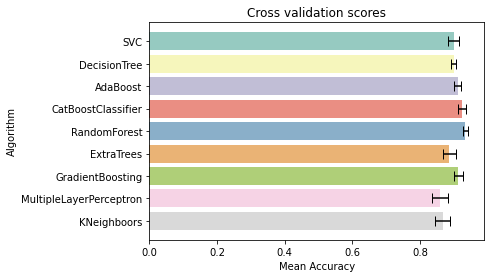

In [34]:
# Cross validate model with Kfold stratified cross val
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from catboost import CatBoostClassifier
kfold = StratifiedKFold(n_splits=2)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(CatBoostClassifier(random_state=random_state))
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X, y, scoring='accuracy', cv=kfold, n_jobs=1))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": ["SVC", "DecisionTree", "AdaBoost","CatBoostClassifier",
                                                                                          "RandomForest", "ExtraTrees", "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors",  "LinearDiscriminantAnalysis"]})
g = sns.barplot(data=cv_res, x='CrossValMeans', y='Algorithm', hue='Algorithm', palette="Set3", orient='h', dodge=False)
g.errorbar(x=cv_res['CrossValMeans'], y=cv_res['Algorithm'], xerr=cv_std, fmt='none', c='black', capsize=5)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")